# Getting Started

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [4]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

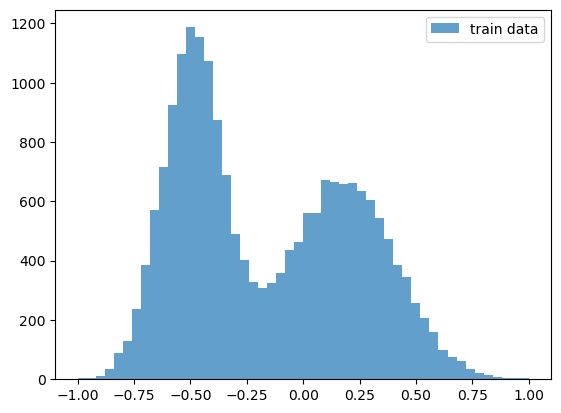

In [5]:
visualize_q1_dataset()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from tqdm.notebook import tqdm

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
def train_gan_minmax(generator, discriminator, g_optimizer, d_optimizer, latent_dim, train_loader, device, num_epochs=100 ):

    # Track discriminator losses
    d_losses = []

    # Store discriminator outputs for eval points
    d_outputs_epoch1 = []
    d_outputs_end = []

    # Samples at epoch 1 and end of training
    samples_epoch1 = []
    samples_end = []

    # Evaluation points
    eval_points = np.linspace(-1, 1, 1000).astype(np.float32)
    eval_points_tensor = torch.tensor(eval_points).unsqueeze(1).to(device)

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        pbar = tqdm(train_loader, unit='batch')
        
        for batch_id, data in enumerate(pbar):

            real_batch = data[0].to(device)

            noise = torch.randn(real_batch.size(0), latent_dim).to(device)
            fake_batch = generator(noise)
            
            # Discriminator training
            d_optimizer.zero_grad()
            real_outputs = discriminator(real_batch)
            fake_outputs = discriminator(fake_batch.detach())
            
            # Discriminator loss: E[log(D(x))] + E[log(1 - D(G(z)))]
            d_loss = -torch.mean(torch.log(real_outputs + 1e-8) + torch.log(1 - fake_outputs + 1e-8))
            d_loss.backward()
            d_optimizer.step()
            d_losses.append(d_loss.item())
            
            # Generator training
            g_optimizer.zero_grad()
            fake_outputs = discriminator(fake_batch)

            # Generator loss: E[log(1 - D(G(z)))]
            g_loss = torch.mean(torch.log(1- fake_outputs + 1e-8))
            g_loss.backward()
            g_optimizer.step()

            pbar.set_description(desc=f"discriminator_loss={d_loss:.4f}")
    
        if epoch == 0 or epoch == num_epochs - 1:
            noise_samples = torch.randn(5000, latent_dim).to(device)

            if epoch == 0:
                with torch.no_grad():
                    samples_epoch1 = generator(noise_samples).cpu().numpy()
                    d_outputs_epoch1 = discriminator(eval_points_tensor).cpu().numpy().flatten()
            
            else:
                with torch.no_grad():
                    samples_end = generator(noise_samples).cpu().numpy()
                    d_outputs_end = discriminator(eval_points_tensor).cpu().numpy().flatten()

    return np.array(d_losses), samples_epoch1, samples_end, d_outputs_epoch1, d_outputs_end, eval_points

In [10]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 8} if torch.backends.mps.is_available() else \
            {}

    # Hyperparameters
    latent_dim = 10
    hidden_dim = 128
    num_epochs = 25
    batch_size = 128
    learning_rate = 0.0002
    beta1 = 0.5


    # Data preprocessing
    train_data = torch.FloatTensor(train_data)

    # Create data loaders
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    
    # Initialize models
    generator = Generator(latent_dim, hidden_dim).to(device)
    discriminator = Discriminator(hidden_dim=hidden_dim).to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

    # Perform training
    d_losses, samples_epoch1, samples_end, d_outputs_epoch1, d_outputs_end, eval_points = train_gan_minmax(
        generator, 
        discriminator,
        optimizer_G,
        optimizer_D,
        latent_dim,
        train_loader, 
        device=device,
        num_epochs=num_epochs,  
    )

    return d_losses, samples_epoch1, eval_points, d_outputs_epoch1, samples_end, eval_points, d_outputs_end


### Results

Using device: mps
Epoch 1/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 6/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 7/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 8/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 9/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 10/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 11/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 12/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 13/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 14/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 15/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 16/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 17/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 18/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 19/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 20/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 21/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 22/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 23/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 24/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 25/25


  0%|          | 0/157 [00:00<?, ?batch/s]

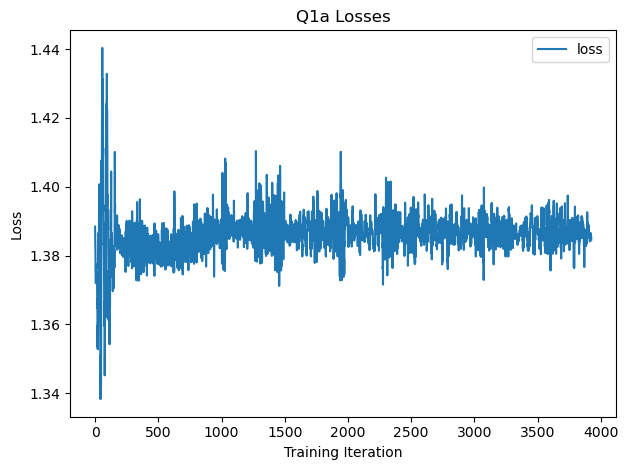

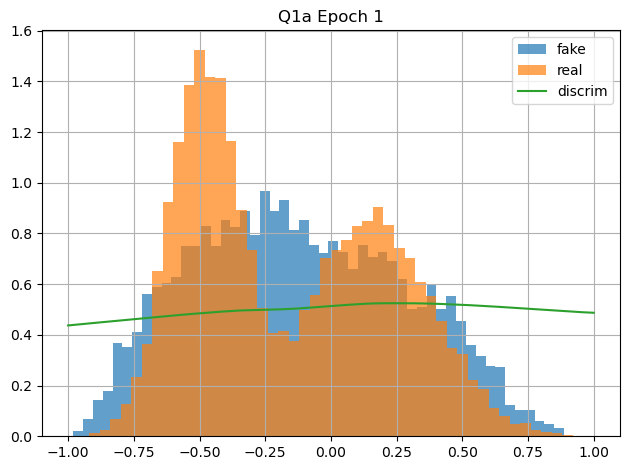

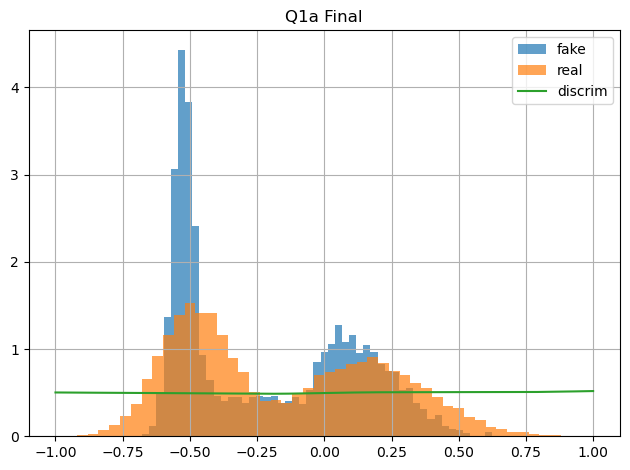

In [11]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [12]:
def train_gan_non_saturating(generator, discriminator, g_optimizer, d_optimizer, latent_dim, train_loader, device, num_epochs=100 ):

    # Track discriminator losses
    d_losses = []

    # Store discriminator outputs for eval points
    d_outputs_epoch1 = []
    d_outputs_end = []

    # Samples at epoch 1 and end of training
    samples_epoch1 = []
    samples_end = []

    # Evaluation points
    eval_points = np.linspace(-1, 1, 1000).astype(np.float32)
    eval_points_tensor = torch.tensor(eval_points).unsqueeze(1).to(device)

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        pbar = tqdm(train_loader, unit='batch')
        
        for batch_id, data in enumerate(pbar):

            real_batch = data[0].to(device)

            noise = torch.randn(real_batch.size(0), latent_dim).to(device)
            fake_batch = generator(noise)
            
            # Discriminator training
            d_optimizer.zero_grad()
            real_outputs = discriminator(real_batch)
            fake_outputs = discriminator(fake_batch.detach())
            
            # Discriminator loss: E[log(D(x))] + E[log(1 - D(G(z)))]
            d_loss = -torch.mean(torch.log(real_outputs + 1e-8) + torch.log(1 - fake_outputs + 1e-8))
            d_loss.backward()
            d_optimizer.step()
            d_losses.append(d_loss.item())
            
            # Generator training
            g_optimizer.zero_grad()
            fake_outputs = discriminator(fake_batch)

            # Generator loss: E[log(1 - D(G(z)))]
            g_loss = -torch.mean(torch.log(fake_outputs + 1e-8))
            g_loss.backward()
            g_optimizer.step()

            pbar.set_description(desc=f"discriminator_loss={d_loss:.4f}")
    
        if epoch == 0 or epoch == num_epochs - 1:
            noise_samples = torch.randn(5000, latent_dim).to(device)

            if epoch == 0:
                with torch.no_grad():
                    samples_epoch1 = generator(noise_samples).cpu().numpy()
                    d_outputs_epoch1 = discriminator(eval_points_tensor).cpu().numpy().flatten()
            
            else:
                with torch.no_grad():
                    samples_end = generator(noise_samples).cpu().numpy()
                    d_outputs_end = discriminator(eval_points_tensor).cpu().numpy().flatten()

    return np.array(d_losses), samples_epoch1, samples_end, d_outputs_epoch1, d_outputs_end, eval_points

In [13]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 8} if torch.backends.mps.is_available() else \
            {}

    # Hyperparameters
    latent_dim = 10
    hidden_dim = 128
    num_epochs = 25
    batch_size = 128
    learning_rate = 0.0002
    beta1 = 0.5


    # Data preprocessing
    train_data = torch.FloatTensor(train_data)

    # Create data loaders
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    
    # Initialize models
    generator = Generator(latent_dim, hidden_dim).to(device)
    discriminator = Discriminator(hidden_dim=hidden_dim).to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

    # Perform training
    d_losses, samples_epoch1, samples_end, d_outputs_epoch1, d_outputs_end, eval_points = train_gan_non_saturating(
        generator, 
        discriminator,
        optimizer_G,
        optimizer_D,
        latent_dim,
        train_loader, 
        device=device,
        num_epochs=num_epochs,  
    )

    return d_losses, samples_epoch1, eval_points, d_outputs_epoch1, samples_end, eval_points, d_outputs_end


 ### Results

Using device: mps
Epoch 1/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 6/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 7/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 8/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 9/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 10/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 11/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 12/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 13/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 14/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 15/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 16/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 17/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 18/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 19/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 20/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 21/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 22/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 23/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 24/25


  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 25/25


  0%|          | 0/157 [00:00<?, ?batch/s]

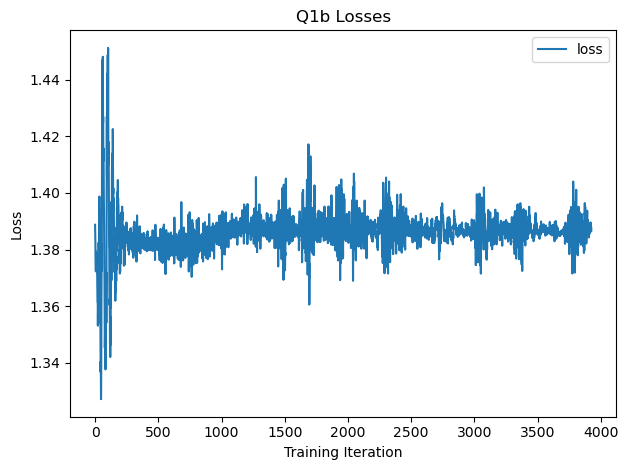

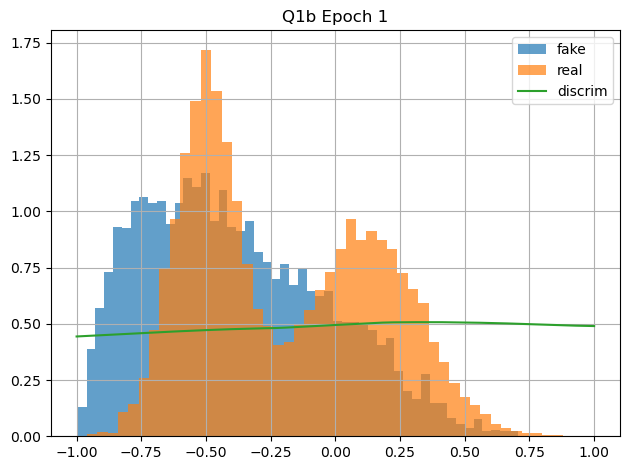

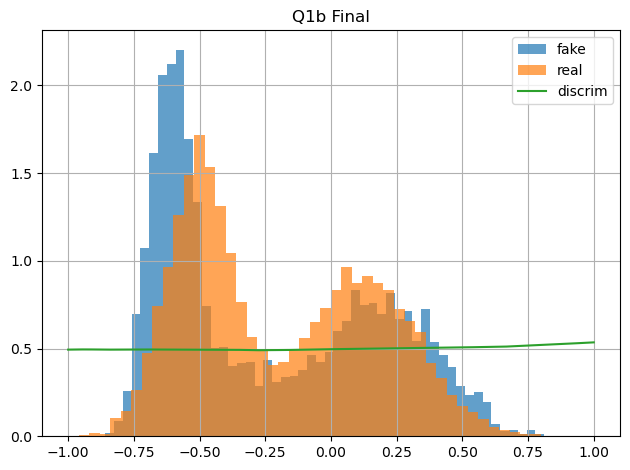

In [14]:
q1_save_results('b', q1_b)